# Neural Network from scratch


In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12345) # Set initial random seed (good to do)


# Activation functions, the parameter f decides which activation function that is used.
def activate(a, f="none"):
    if f == "none":
        y = a
    elif f == "relu":
        y = np.maximum(a,0)
    elif f == "softmax":
        a = a - np.max(a, axis=1, keepdims=True)
        ex = np.exp(a)
        y =  ex / np.sum(ex, axis=1, keepdims=True)
    return y

# Derivatives of activation functions
def d_activate(a, f="none"):
    if f=="none":
        dy = np.ones_like(a)
    elif f == "relu":
        dy = 1 * (a > 0)
    elif f == "softmax":
        dy = np.ones_like(a)
    return dy

# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    return 1/2 * np.mean((y_hat-y)**2)

# This is the derivative of the loss with respect to the predicted value y_hat
def d_MSE_loss(y_hat, y):
    m = y.shape[0]
    return 1./m * (y_hat-y)

# Cross-entropy loss function for multiclass classification
def multiclass_cross_entropy(y_hat, y):
    ce = (-y * np.log(y_hat + 1e-8)).mean()
    return ce

# Derivative of multiclass cross-entropy loss function
def d_multiclass_cross_entropy(y_hat, y):
    d_loss = y_hat - y
    return d_loss

# Propagate a signal through a layer in a neueral network.
def propagate_forward(w, a, biases, f="none"):
    z = activate((np.dot(a,w) + biases), f)
    return z
    
# Calculate the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights w and the input signal a.
def propagate_backward(w, a, dl_dz, biases, f="none"):
    # w = weights
    # a = activations of the previous layer
    # dl_dz = derivative of the loss with respect to the activations in the current layer

    # Loss gradient (current means activations of the current layer)
    dl = d_activate(np.dot(a,w) + biases, f) * dl_dz


    # Loss gradient with respect to weights
    dw = np.dot(a.T, dl)
    # Loss gradient with respect to bias
    db = np.sum(dl, axis=0, keepdims=True) # https://datascience.stackexchange.com/questions/20139/gradients-for-bias-terms-in-backpropagation
    # Loss gradient with respect to precedent activations
    da = np.dot(dl, w.T)
    
    return dw, da, db

def calculcate_accuracy(predictions, y, task):
    if task == "regression":
        return MSE_loss(predictions, y)
    else:
        preds = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(preds == true_labels)
        return accuracy


## An implementation of a neural network

In [4]:


# A class for a neural network
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    def __init__ (self, input_dim, output_dim, neurons, task="regression", alpha=1e-4):
        
        # Gradients
        self.ws = [np.random.normal(0, 2,(n,m)) for n,m in
                   zip([input_dim] + neurons, neurons + [output_dim])]
        # Output Layer
        self.output_layer = "relu" if task == "regression" else "softmax"
        # Activation functions for each layer
        self.activations = ["relu"] * len(neurons) + [self.output_layer]
        self.alpha = alpha

        self.biases = np.random.normal(0, 2, size=len(neurons) + 1)
        self.task = task
    
    
    # Predict the input throught the network and calculate the output.
    def forward(self, x):
        for w,f,b in zip(self.ws, self.activations, self.biases):
            x = propagate_forward(w,x,b,f)
        return x
    
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    def adjust_weights(self, x, y):
        a = x
        al = []

        
        for w,f,b in zip(self.ws, self.activations, self.biases):
            al.append(a)
            a = propagate_forward(w,a,b,f)

        if self.task == "classification":
            # Classification
            loss = multiclass_cross_entropy(a, y)
            da = d_multiclass_cross_entropy(a, y)
        else:
            # Regression
            loss = MSE_loss(a, y)
            da = d_MSE_loss(a, y)
        
        for w,f,x,b in reversed(list(zip(self.ws, self.activations, al, self.biases))):
            # Backpropagation
            dw, da, db = propagate_backward(w,x,da,b,f)
            # Gradient Descent
            w -= self.alpha * dw
            b -= self.alpha * db


        return loss
    
    def suffle_dataset(self, x, y):
        randomize = np.arange(len(x))
        np.random.shuffle(randomize)
        x = x[randomize]
        y = y[randomize]
        return x, y

    def get_data_batched(self, x, y, batch_size):
        batches_x = [x[i:i + batch_size] for i in range(0, len(x), batch_size)]
        batches_y = [y[i:i + batch_size] for i in range(0, len(y), batch_size)]
        return batches_x, batches_y
        
    # A function for the training of the network.
    def train_net(self, x, y, batch_size=64, epochs=100, debug=False):
        epo_loss = []
        epo_acc = []

        for epoch in range(epochs):
            predictions = []
            losses = []

            random_x, random_y = self.suffle_dataset(x.copy(), y.copy())
            batches_x, batches_y = self.get_data_batched(random_x, random_y, batch_size)

            for batch_x, batch_y in zip(batches_x, batches_y):
                pred = self.forward(batch_x)
                predictions.append(pred)

                loss = self.adjust_weights(batch_x, batch_y)
                losses.append(loss)

            mean_loss = np.array(losses).mean()
            if self.task == "classification":
                predictions = np.concatenate(np.array(predictions))
                accuracy = calculcate_accuracy(predictions, random_y, self.task)
                epo_acc.append(accuracy)
                if debug is True:
                    print("Epoch n°" + str(epoch) + " - Accuracy: ", accuracy)
                    print("MSE: ", mean_loss)
            elif debug is True:
                print("Epoch n°" + str(epoch) + " - MSE: ", mean_loss)
            epo_loss.append(mean_loss)
        return epo_loss, epo_acc

    def predict(self, x):
        predictions = self.forward(x)
        return predictions


## Main programs

In [5]:
def plot_loss_and_accuracy(loss, acc, dataset_name):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(loss)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Progression of Loss for " + dataset_name)

    if len(acc) > 0:
        ax[1].plot(acc)
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].set_title("Progression of Accuracy for " + dataset_name)

    plt.show()

def my_one_hot_encoder(data):
    one_hot_encoding_data = []
    encode = np.unique(data)
    size = len(encode)

    for i in data:
        one_hot = [0 for i in range(size)]

        idx = np.where(encode == i)[0][0]
        one_hot[idx] = 1.
        one_hot_encoding_data.append(one_hot)

    return np.array(one_hot_encoding_data)

def my_train_test_split(X, y, test_size=0.33):
    # This function supposes that we already have randomized rows
    size = X.shape[0]
    index = int(size - (size * test_size))

    try:
        X = X.to_numpy()
        y = y.to_numpy()
        return X[:index], X[index:], y[:index], y[index:]
    except:
        return X[:index], X[index:], y[:index], y[index:]



import pandas as pd

def split_tmls_to_X_and_y(data, label_to_remove = None):
    new_data = data.sample(frac = 1, random_state=1) # Suffle rows of the data set
    if (not(label_to_remove is None)):
        new_data = new_data[new_data["class"] != label_to_remove] # Drop class
    X_data = new_data.iloc[:, 0:-1].apply(pd.to_numeric, errors='coerce')
    y_target = new_data.iloc[:, -1]
    return X_data, y_target


/tmp/ipykernel_10304/1975928034.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.concatenate(np.array(predictions))


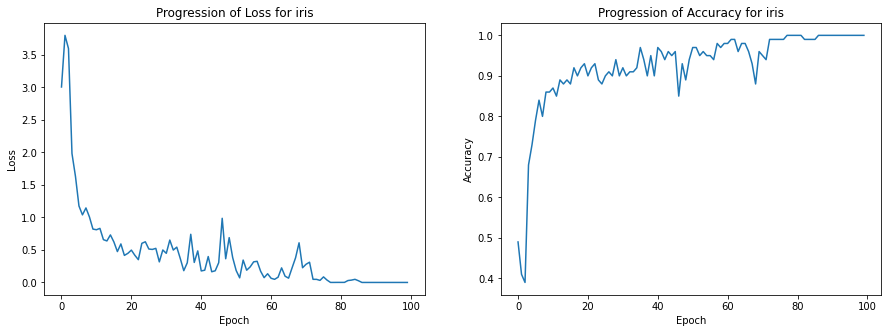

Accuracy on test set:  0.74
------------------------------------------------------------------




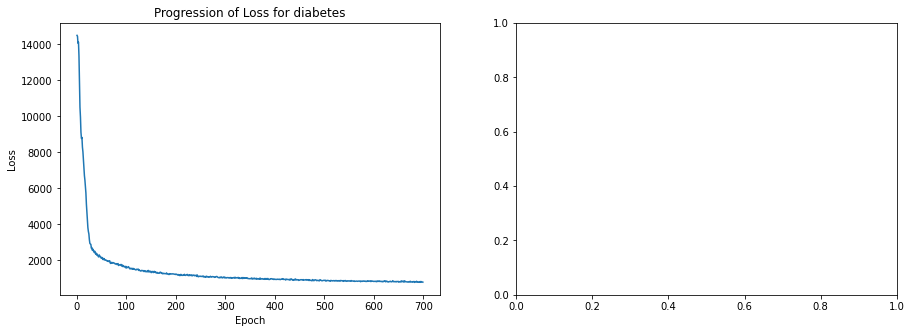

Accuracy on test set:  2054.366087322525
------------------------------------------------------------------




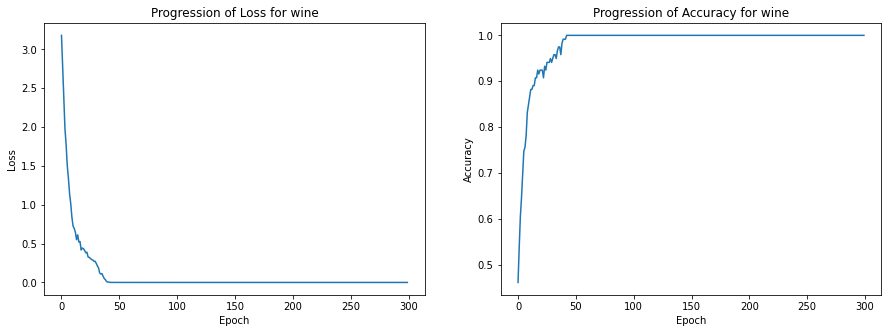

Accuracy on test set:  0.864406779661017
------------------------------------------------------------------




In [6]:
np.random.seed(12345) # Set initial random seed (good to always do)

datasets = [
    {
        "name": "iris",
        "task": "classification",
        "alpha": 1e-5,
        "epochs": 100,
        "neurons": [15, 15, 15, 15, 15]
    },
    {
        "name": "diabetes",
        "task": "regression",
        "alpha": 1e-4,
        "epochs": 700,
        "neurons": [15, 5]
    },
    {
        "name": "wine",
        "task": "classification",
        "alpha": 1e-4,
        "epochs": 300,
        "neurons": [20, 20]
    }
]

for dataset in datasets:
    # Open dataset
    df_dataset = pd.read_csv(dataset["name"] + ".tmls")
    data = df_dataset.drop(0) # Remove first row
    X, y = split_tmls_to_X_and_y(data)
    X=(X-X.mean())/X.std()

    if dataset["task"] == "classification":
        y = my_one_hot_encoder(y) # Put y in one-hot encoding
    else:
        y = y.apply(pd.to_numeric, errors='coerce') # Put y in numeric
    
    X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=0.33)

    input_dim = X_train.shape[1]
    if dataset["task"] == "classification":
        output_dim = len(y_train[0])
    else:
        output_dim = 1
        y_train = y_train.reshape(len(y_train), 1)
        y_test = y_test.reshape(len(y_test), 1)

    # learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    nn = NeuralNet(input_dim, output_dim, dataset["neurons"], dataset["task"], alpha=dataset["alpha"])
    loss, acc = nn.train_net(X_train, y_train, epochs=dataset["epochs"])
    
    plot_loss_and_accuracy(loss, acc, dataset["name"])
    predictions = nn.predict(X_test)
    final_accuracy = calculcate_accuracy(predictions, y_test, dataset["task"])
    print("Accuracy on test set: ", final_accuracy)

    print("------------------------------------------------------------------\n\n")



In [40]:
np.random.seed(12345) # Set initial random seed (good to always do)

alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
layer_sizes = [ [15, 15], [2, 4], [100] ]
epoch = 100
task = "classification"
dataset_name = "iris"

scores = []

for alpha in alphas:
    for layer in layer_sizes:

        df_dataset = pd.read_csv(dataset_name + ".tmls")
        data = df_dataset.drop(0) # Remove first row
        X, y = split_tmls_to_X_and_y(data)
        X=(X-X.mean())/X.std()

        if dataset["task"] == "classification":
            y = my_one_hot_encoder(y) # Put y in one-hot encoding
        else:
            y = y.apply(pd.to_numeric, errors='coerce') # Put y in numeric
        
        X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=0.33)

        input_dim = X_train.shape[1]
        if dataset["task"] == "classification":
            output_dim = len(y_train[0])
        else:
            output_dim = 1
            y_train = y_train.reshape(len(y_train), 1)
            y_test = y_test.reshape(len(y_test), 1)

        # learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

        nn = NeuralNet(input_dim, output_dim, layer, task, alpha=alpha)
        loss, acc = nn.train_net(X_train, y_train, epochs=epoch)
        
        predictions = nn.predict(X_test)
        accuracy = calculcate_accuracy(predictions, y_test, dataset["task"])

        obj = {
            "alpha": alpha,
            "layer": str(layer),
            "acc": accuracy
        }
        scores.append(obj)

print(scores)

/tmp/ipykernel_10304/1975928034.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.concatenate(np.array(predictions))


[{'alpha': 0.1, 'layer': '[15, 15]', 'acc': 0.38}, {'alpha': 0.1, 'layer': '[2, 4]', 'acc': 0.5}, {'alpha': 0.1, 'layer': '[100]', 'acc': 0.38}, {'alpha': 0.01, 'layer': '[15, 15]', 'acc': 0.38}, {'alpha': 0.01, 'layer': '[2, 4]', 'acc': 0.38}, {'alpha': 0.01, 'layer': '[100]', 'acc': 0.86}, {'alpha': 0.001, 'layer': '[15, 15]', 'acc': 0.54}, {'alpha': 0.001, 'layer': '[2, 4]', 'acc': 0.54}, {'alpha': 0.001, 'layer': '[100]', 'acc': 0.86}, {'alpha': 0.0001, 'layer': '[15, 15]', 'acc': 0.7}, {'alpha': 0.0001, 'layer': '[2, 4]', 'acc': 0.4}, {'alpha': 0.0001, 'layer': '[100]', 'acc': 0.82}, {'alpha': 1e-05, 'layer': '[15, 15]', 'acc': 0.64}, {'alpha': 1e-05, 'layer': '[2, 4]', 'acc': 0.36}, {'alpha': 1e-05, 'layer': '[100]', 'acc': 0.58}, {'alpha': 1e-06, 'layer': '[15, 15]', 'acc': 0.14}, {'alpha': 1e-06, 'layer': '[2, 4]', 'acc': 0.24}, {'alpha': 1e-06, 'layer': '[100]', 'acc': 0.02}]


In [41]:
from IPython.display import HTML
import seaborn as sns

df = pd.DataFrame(scores)

# Pivot the DataFrame to create a table of results
table = pd.pivot_table(df, values='acc', index='layer', columns='alpha')
table = table.sort_index()

# cm = sns.light_palette("grey", as_cmap=True)
# table = table.style.background_gradient(cmap=cm)

def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

table = table.style.apply(highlight_max, color='darkorange', axis=None)

HTML(table.to_html())

alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1
layer,,,,,,
[100],0.020000,0.580000,0.820000,0.860000,0.860000,0.380000
"[15, 15]",0.140000,0.640000,0.700000,0.540000,0.380000,0.380000
"[2, 4]",0.240000,0.360000,0.400000,0.540000,0.380000,0.500000
